In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('usd_curve_basic.csv')
times = data['t'].values
df0 = data['df'].values

#data = pd.read_csv('LMM_data1.csv')
#times = data['t'].values
#df0 = data['df'].values

sims = 500
timesteps = 15 
x0 = 0
a = 0.1
sig = 0.02
T = 5

#print(df0)

def hw_exp(a, x, t1, t2):
    return x * np.exp(-a * (t2 - t1))

def hw_var(a, sig, t1, t2):
    return sig ** 2 * (1 - np.exp(-2 * a * (t2 - t1))) / (2 * a)

x = np.zeros((sims, timesteps))
    
for i in range(sims):
    x[i,0] = x0
    for j in range(1, timesteps):
        Z1 = np.random.normal(0,1)
        x[i,j] = hw_exp(a, x[i,j-1], j-1, j) + Z1 * (hw_var(a, sig, j-1, j) ** 0.5) # possible need a rt time in here
            
#print(x)

In [123]:
# discount factors
# j is one timestep before point we are calculating - THIS MIGHT NEED CORRECTING -  think it is right

def cov(sig, i, j):
    return sig ** 2 * (np.exp(-a * abs(j - i)) - np.exp(-a * (j + i))) / (2 * a)

def q(a, i, j):
    return (1 - np.exp(-a * (j - i))) / a

def phi(sig, j):
    phi = 0
    for i in range(j - 1):
        phi += q(a, i, j) * cov(sig, i, j)
    return phi
    
def gamma(j):
    return 0.5 * cov(sig, j, j)
    
def hwdf(t, T, x, a, sig):
    B_tn = np.interp(t, times, df0)
    B_T = np.interp(T, times, df0)
    if t == 0:
        discount_factor = B_tn / B_T
    else:
        discount_factor = (B_tn / B_T) * np.exp(- (x + phi(sig, t)) * q(a, t, T) - (gamma(t) * q(a, t, T) ** 2) )
    return discount_factor

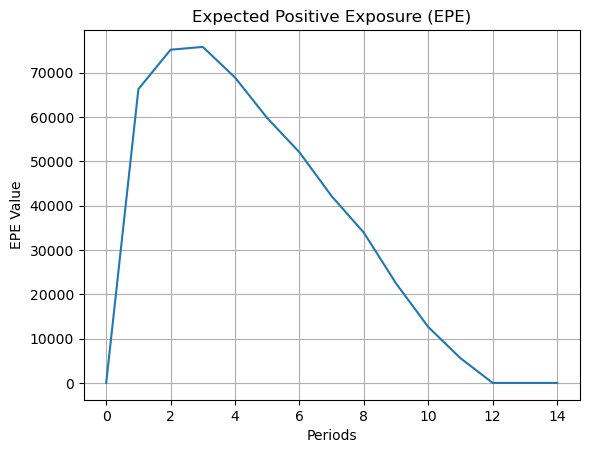

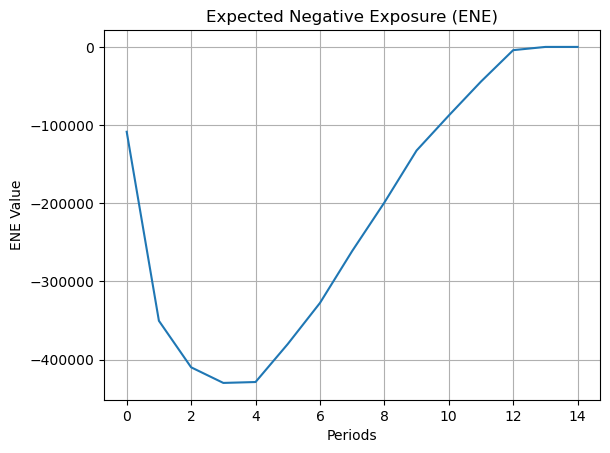

In [125]:
np.seterr(divide='ignore')

df = np.zeros((sims, timesteps, timesteps + 1))
fwd = np.zeros((sims, timesteps, timesteps + 1))
dt = 1

Notional = np.zeros(timesteps + 1)
fixed_rate = np.zeros(timesteps + 1)
Timestep = np.zeros(timesteps + 1)

MtM = np.zeros((sims, timesteps))

for k in range(timesteps + 1):
    fixed_rate[k]= 0.004
    Notional[k] = 1000000
    Timestep[k] = 1

for i in range(sims):
    for j in range(timesteps):
        sumfxd = 0
        sumflt = 0
        for k in range(j, timesteps - 1):
            df[i, j, k] = hwdf(k, j, x[i, j], a, sig)

        for k in range(j,  timesteps  - 1):
            if df[i, j, k] != 0:
                fwd[i, j, k + 1] = - np.log(df[i, j, k + 1] / df[i, j, k]) / dt
            else:
                fwd[i, j, k + 1] = 0
            
            sumfxd += Timestep[k] * Notional[k] * fixed_rate[k] * df[i, j, k + 1]
            sumflt += Timestep[k] * Notional[k] * fwd[i, j, k] * df[i, j, k + 1]

        MtM[i, j] = sumflt - sumfxd

EPE = np.mean(np.where(MtM > 0, MtM, 0), axis=0)
EPE_rounded = np.round(EPE).astype(int)
formatted_EPE = ', '.join(map(str, EPE_rounded))
#print(formatted_EPE)

plt.plot(range(timesteps), EPE_rounded)
plt.title('Expected Positive Exposure (EPE)')
plt.xlabel('Periods')
plt.ylabel('EPE Value')
plt.grid(True)
plt.show()

ENE = np.mean(np.where(MtM < 0, MtM, 0), axis=0)
ENE_rounded = np.round(ENE).astype(int)
formatted_ENE = ', '.join(map(str, ENE_rounded))
#print(formatted_ENE)

plt.plot(range(timesteps), ENE_rounded)
plt.title('Expected Negative Exposure (ENE)')
plt.xlabel('Periods')
plt.ylabel('ENE Value')
plt.grid(True)
plt.show()

In [ ]:
#different implementation of HW 